## load necessary packages ##

In [1]:
import pandas as pd
import numpy as np
import torch


## Load datasets ##

In [ ]:
# Load the dataset
df_train = pd.read_csv('/Users/richardzeng/Desktop/EMNLP/experiments/talk2me/threshold_2_train_test_Data/train.csv')
df_test = pd.read_csv('/Users/richardzeng/Desktop/EMNLP/experiments/talk2me/threshold_2_train_test_Data/test.csv')

In [3]:
#see how many data points are in each dataset
print(df_train.shape)
print(df_test.shape)

# change the column names to 'text' and 'label'
df_train.columns = ['text', 'label']
df_test.columns = ['text', 'label']

# print the first 5 rows of the training data
print(df_train.head())

# check the number of 1s and 0s in the training data
print()
print(df_train['label'].value_counts())


(1848, 2)
(463, 2)
                                                text  label
0  A WHAT TO ME LOOKS LIKE A KINDEGATIN CLASTERIN...      0
1  A MAN IS SITTING ON A BENCH AGAINST THE WALL B...      0
2  I SAY THREE ELDERLY LADIES WITH GREY HAIR WHO ...      0
3  THIS IS A SCENE OF TWO FIREMEN FIGHTING AY FIR...      0
4  I HAVE A PICTURE IN FRONT OF ME OF A MAN IN A ...      1

label
0    1555
1     293
Name: count, dtype: int64


## Exploratory data analysis ##

Text(0.5, 1.0, 'Distribution of labels in the training data')

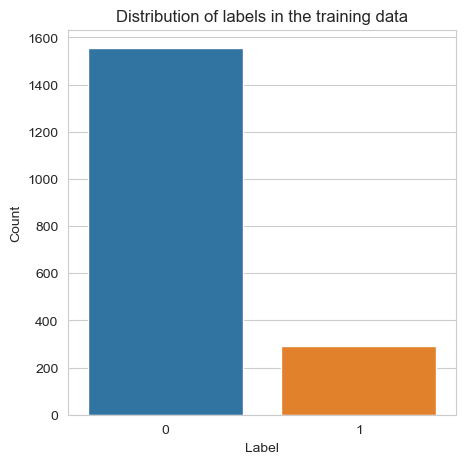

In [4]:
#plot the distribution of the labels
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 5))
sns.countplot(x='label', data=df_train)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of labels in the training data')


In [5]:
df_train.groupby('label').describe().T

label                                                        0  \
text count                                                1555   
     unique                                               1555   
     top     A WHAT TO ME LOOKS LIKE A KINDEGATIN CLASTERIN...   
     freq                                                    1   

label                                                        1  
text count                                                 293  
     unique                                                293  
     top     I HAVE A PICTURE IN FRONT OF ME OF A MAN IN A ...  
     freq                                                    1

/Users/richardzeng/opt/anaconda3/envs/EMNLP/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of text length in the training data')

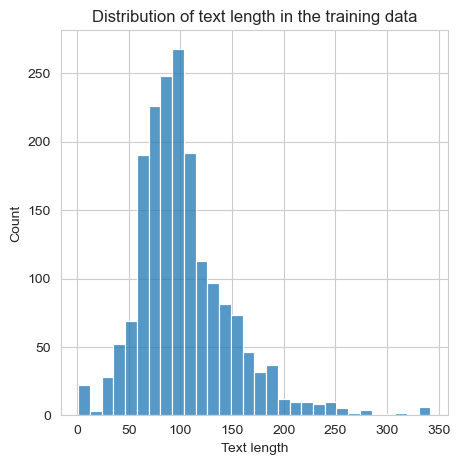

In [6]:
#text length distribution
df_train['text_length'] = df_train['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(5, 5))
sns.histplot(df_train['text_length'], bins=30)
plt.xlabel('Text length')
plt.ylabel('Count')
plt.title('Distribution of text length in the training data')


In [7]:
text_length = []
for text in df_train['text']:
    text_length.append(len(text.split()))
print('Average text length:', np.mean(text_length))
print('Max text length:', np.max(text_length))
print('Min text length:', np.min(text_length))


Average text length: 103.30357142857143
Max text length: 342
Min text length: 1


In [8]:
# remove text with less than 3 words
df_train = df_train[df_train['text_length'] >= 5]

## Look into long texts ##

In [9]:
df_train.sort_values(by='text_length', ascending=False).head(10)

,text,label,text_length
350,AND THIS IS A PICTURE OF A BEACH SCEN THERE IS...,0,342
44,THERE ARE THREE CHILDREN BEING CARRIED AWAY BY...,0,340
2,I SAY THREE ELDERLY LADIES WITH GREY HAIR WHO ...,0,338
872,WHAT I SEE IS A SKY THE NIGHT SKY FULL OF STAR...,1,335
660,A MAN AND HIS SON A WALKING IN THE RAIN THE SO...,0,334
675,IT'S A FINE DAY OVERCAST BUT FINE AH PEOPLE AR...,0,334
1033,THIS SCENE IS OF A MEN WHOSE CAR HAS AM THOUGH...,0,317
914,IT'S A RAINY DAY THERE ARE AM TWO PEOPLE BY SI...,0,312
1399,THERE IS A GROUP OF FOUR PEOPLE TALKING TWO AP...,0,302
545,I CAN SEE A MAN HOLDING THREE JARS IN EACH JAR...,0,292


In [10]:
# check the label distribution after removing the short texts
print(df_train['label'].value_counts())

label
0    1545
1     290
Name: count, dtype: int64


## Preprocessing ##

In [11]:
# remove the text that are not from the picture discription task. (i.e. the text that has "my grandfather is...ninety three...")
keywords = ['grandfather', 'rainbow', 'duck', 'sun', 'lim','lympy', 'red', 'yellow', 'rainbor']

# Function to check if any keyword is in the text
def contains_keywords(text, keywords):
    return any(keyword in text.lower() for keyword in keywords)

# Remove the texts that contain the keywords
df_train = df_train[~df_train['text'].apply(lambda x: contains_keywords(x, keywords))]
df_test = df_test[~df_test['text'].apply(lambda x: contains_keywords(x, keywords))]



In [18]:
# check the label distribution after removing the texts
print(df_train['label'].value_counts())
print(df_test['label'].value_counts())

# save the preprocessed data
df_train.to_csv('/Users/richardzeng/Desktop/EMNLP/experiments/talk2me/threshold_2_train_test_Data/train_preprocessed.csv', index=False)
df_test.to_csv('/Users/richardzeng/Desktop/EMNLP/experiments/talk2me/threshold_2_train_test_Data/test_preprocessed.csv', index=False)

label
0    327
1     62
Name: count, dtype: int64
label
0    82
1    17
Name: count, dtype: int64


In [22]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the dataset

train_data = pd.read_csv('/Users/richardzeng/Desktop/EMNLP/experiments/talk2me/threshold_2_train_test_Data/train_preprocessed.csv')
test_data = pd.read_csv('/Users/richardzeng/Desktop/EMNLP/experiments/talk2me/threshold_2_train_test_Data/test_preprocessed.csv')

# Define tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Tokenize the text data
def tokenize_data(data, tokenizer, max_length=128):
    return tokenizer(
        data['text'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_data, tokenizer)
test_encodings = tokenize_data(test_data, tokenizer)

# Convert labels to tensor
train_labels = torch.tensor(train_data['label'].tolist())
test_labels = torch.tensor(test_data['label'].tolist())

# Create a dataset class
class PictureDescriptionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PictureDescriptionDataset(train_encodings, train_labels)
test_dataset = PictureDescriptionDataset(test_encodings, test_labels)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    learning_rate=0.00001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1)),
        'precision': precision_recall_fscore_support(p.label_ids, p.predictions.argmax(-1), average='binary')[0],
        'recall': precision_recall_fscore_support(p.label_ids, p.predictions.argmax(-1), average='binary')[1],
        'f1': precision_recall_fscore_support(p.label_ids, p.predictions.argmax(-1), average='binary')[2],
    },
)

# Train the model
trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()
print(f"Evaluation result: {eval_result}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/richardzeng/opt/anaconda3/envs/EMNLP/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/l9/qqb85lxn7d38y07pzrx88zvw0000gn/T/ipykernel_44528/1943318227.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000
9,0.271100,0.488184,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000
9,0.271100,0.488184,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000
9,0.271100,0.488184,0.828283,0.000000,0.000000,0.000000
10,0.344400,0.486563,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000
9,0.271100,0.488184,0.828283,0.000000,0.000000,0.000000
10,0.344400,0.486563,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000
9,0.271100,0.488184,0.828283,0.000000,0.000000,0.000000
10,0.344400,0.486563,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000
9,0.271100,0.488184,0.828283,0.000000,0.000000,0.000000
10,0.344400,0.486563,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000
9,0.271100,0.488184,0.828283,0.000000,0.000000,0.000000
10,0.344400,0.486563,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000
9,0.271100,0.488184,0.828283,0.000000,0.000000,0.000000
10,0.344400,0.486563,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000
9,0.271100,0.488184,0.828283,0.000000,0.000000,0.000000
10,0.344400,0.486563,0.828283,0.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663400,0.648161,0.787879,0.166667,0.058824,0.086957
2,0.594000,0.566327,0.818182,0.000000,0.000000,0.000000
3,0.549400,0.511111,0.828283,0.000000,0.000000,0.000000
4,0.484700,0.484960,0.828283,0.000000,0.000000,0.000000
5,0.377200,0.474897,0.828283,0.000000,0.000000,0.000000
6,0.448200,0.474920,0.828283,0.000000,0.000000,0.000000
7,0.456100,0.480492,0.828283,0.000000,0.000000,0.000000
8,0.406500,0.479638,0.828283,0.000000,0.000000,0.000000
9,0.271100,0.488184,0.828283,0.000000,0.000000,0.000000
10,0.344400,0.486563,0.828283,0.000000,0.000000,0.000000


/var/folders/l9/qqb85lxn7d38y07pzrx88zvw0000gn/T/ipykernel_44528/1943318227.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Evaluation result: {'eval_loss': 0.5944739580154419, 'eval_accuracy': 0.8181818181818182, 'eval_precision': 0.46153846153846156, 'eval_recall': 0.35294117647058826, 'eval_f1': 0.4000000000000001, 'eval_runtime': 1.1575, 'eval_samples_per_second': 85.531, 'eval_steps_per_second': 6.048, 'epoch': 15.0}
